<h4> Zadanie1: Zaimplementuj algorytm grupowania górskiego Zastosuj do poniższych danych.

In [221]:
import math
from numpy import linalg as LA
import numpy as np

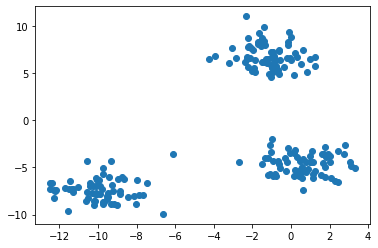

In [222]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
X, y, og_centers = make_blobs(n_samples=200, random_state=100, n_features=2, centers = 3, cluster_std = 1.2, return_centers= True)

plt.scatter(X[:, 0], X[:, 1])
plt.show()

robię siatkę punktów, dla których będe wyznaczał wartości funkcji grupowania górskiego

In [223]:
grid_points = [math.floor(min(X[:,0])),   math.floor(min(X[:,1])),  math.ceil(max(X[:,0])),   math.ceil(max(X[:,1]))]

rows = grid_points[3] - grid_points[1] + 1

grid = []
for i in np.arange(grid_points[0],grid_points[2], 0.2):
  for j in np.arange(grid_points[1],grid_points[3], 0.2):
    grid.append([i,j])



In [225]:
def mountain_function (data, density_centers, sigma = 3, b = 1):
  result = []
  for center in density_centers:
      g_c = sum([math.exp(-((LA.norm(center - data[ix]) ** (2 * b)) / (2 * (sigma ** 2)))) for ix in range(len(data))])
      result.append(g_c)
  return result


In [226]:
def recalculate_mountain (mountain, centrum, center_coor, grid, sigma = 3, b = 1):
  new_result = []
  for ix, value in enumerate(mountain):

    new_mountain = value - centrum * (math.exp(-((LA.norm(np.array(center_coor) - np.array(grid[ix])) ** (2 * b)) / (2 * (sigma ** 2)))))
    new_result.append(new_mountain)

  a = new_result.index(max(new_result))
  centrum_x = new_result[a]
  return new_result, a, centrum_x




In [227]:
def find_cluster_centers(number, data, grid):

  cluster_centers = []

  mountain = mountain_function(X, grid)
  a = mountain.index(max(mountain))
  centrum_x = mountain[a]
  cluster_centers.append(grid[a])

  for c in range (number - 1):
    mountain, a, centrum_x = recalculate_mountain(mountain, centrum_x, grid[a], grid)
    cluster_centers.append(grid[a])

  return cluster_centers


In [228]:
found_centers = find_cluster_centers(3, X, grid)

In [229]:
print(found_centers)

[[0.5999999999999517, -4.600000000000019], [-1.200000000000042, 6.79999999999994], [-10.00000000000001, -7.400000000000009]]


Algorytm dosyć dobrze poradził sobie z wyznaczeniem centrów. Grid generowany co 0.2 mógł zaburzyć wynik, ale puszczanie na większej ilości punktów bardzo zwiększa złożoność obliczeniową.





In [230]:

og_centers


array([[ 0.86809884, -4.4326123 ],
       [-1.50964819,  6.89552265],
       [-9.90562288, -7.56861758]])

In [231]:
Y_class = []
for data_point in X:
  X_array = []
  for center in found_centers:
    X_array.append(LA.norm(center - data_point))
  index = X_array.index(min(X_array))
  Y_class.append(index)



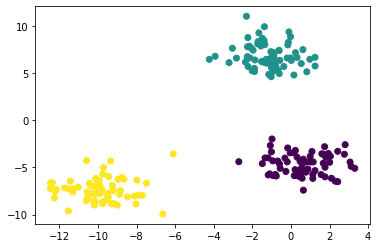

In [232]:
plt.scatter(X[:, 0], X[:, 1], c = Y_class)
plt.show()

Udało się, ale można by poprawić początkowe wyznaczanie siatki, chociaż nie poprawi to implementacji algorytmu, który chyba został zaimplementowany ok. Można by się pokusić też o metodę generowania gridu dla więcej niż 2 wymiarów, ale sama idea algorytmu będzie również działała dla takich danych.

<h4> Zadanie2: Zaimplementuj algorytm Gustafsona-Kessela. Zastosuj go do poniższych danych - algorytm powinien sobie poradzić z poprawną klasyfikacją.

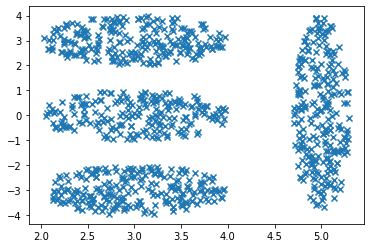

In [241]:
n = 10000
x = np.random.uniform(-6, 6, n)
y = np.random.uniform(-6, 6, n)

x1 = []
y1 = []
for i in range(n):
    if ((x[i]-5)**2)/0.3**2+((y[i]-0)**2)/4**2 <=1 or ((x[i]-3)**2)/1**2+((y[i]-3)**2)/1**2 <=1 or ((x[i]-3)**2)/1**2+((y[i]-0)**2)/1**2 <=1 or ((x[i]-3)**2)/1**2+((y[i]+3)**2)/1**2 <=1:
        x1.append(x[i])
        y1.append(y[i])
X = np.array([[x,y] for (x,y) in zip(x1,y1)])

plt.scatter(X[:,0],X[:,1], marker = "x")
plt.show()

In [242]:
grid_points = [math.floor(min(X[:,0])),   math.floor(min(X[:,1])),  math.ceil(max(X[:,0])),   math.ceil(max(X[:,1]))]

rows = grid_points[3] - grid_points[1] + 1

grid = []
for i in np.arange(grid_points[0],grid_points[2], 0.2):
  for j in np.arange(grid_points[1],grid_points[3], 0.2):
    grid.append([i,j])


In [243]:
# new norm 
def improved_norm (center, data_point, matrix):
  return np.sqrt( np.dot( (data_point - center).T , np.dot(matrix,  (data_point - center)) ) )
  

In [244]:
# recalculate membership
def recalculate_member (found_centers, X, A_matrices):
  membership = []
  for indecx, data_point in enumerate(X):
    new_memberships = []
    for indx, center in enumerate(found_centers):
      new_memberships.append(1 / sum([ ((improved_norm(center, data_point, A_matrices[indx]) / improved_norm(cente, data_point, A_matrices[inx])) \
                                      ** (2 / (m - 1) )) for inx, cente in enumerate(found_centers) ]))
    membership.append(new_memberships)
  return membership


In [245]:
# new center coordinates
def recalculate_centers(found_centers, X, whole_mem_mat, m) :
  
  for ix, center in enumerate(found_centers):
    sum_1, sum_2 = 0, 0

    for ind, data_point in enumerate(X):
      sum_1 += whole_mem_mat[ind][ix]**m * data_point
      sum_2 += whole_mem_mat[ind][ix]**m 

    found_centers[ix] = sum_1/sum_2
  return found_centers


In [246]:
# covariance matrices
def calculate_covariance_matrices(X, found_centers, m, whole_mem_mat):
  whole_mem_mat = np.array(whole_mem_mat)
  found_centers = np.array(found_centers)
  whole_mem_mat2 = whole_mem_mat ** m
  X = np.array(X)
  covariance_matrices = []

  for ix, center in enumerate(found_centers):
    current = []
    mi = np.sum(whole_mem_mat2[ix] , axis=0) #suma w kolumnach

    mtx = sum([np.dot((data_point - center).reshape((data_point - center).shape[0],1) , \
                  (data_point - center).reshape((data_point - center).shape[0],1).T) for data_point in X])
    
    current = np.dot(mi,mtx) / mi

    covariance_matrices.append(current)
  return covariance_matrices

In [247]:
# A matrices
def recalculate_A_matrices(A_matrices, covariance_matrix, dimension) :
  A_list = []
  for ix, A in enumerate(A_matrices):
    a = (LA.det(covariance_matrix[ix]) ** (1/dimension)).astype(float)
    b = LA.inv(covariance_matrix[ix])
    B = a * b

# mialem problem z uzupelnieniem tej macierzy na nowo wiec zrobilem to tak
    A[0][0] = B[0][0]
    A[0][1] = B[0][1]
    A[1][0] = B[1][0]
    A[1][1] = B[1][1]
    A_list.append(A)
  return A_list

In [343]:
# initial parameters :
m = 5 # m coefficient
A_matrices = []
dimension = 2 # dimension of the A matix
for center in found_centers:
  A_matrices.append(np.array(np.identity(dimension)))


iter = 100
difference = 1.01
flag = 1
covariance_mtx = []
previous_cov_mat = np.array([[1,1],[1,1]])

# step 1 - mountain grouping algorithm to acquire initial centers: 
found_centers = find_cluster_centers(4, X, grid)


while (difference > 1 and iter > 0) :

  # step 2 - calculate membership matrices:
  whole_mem_mat = recalculate_member(found_centers, X, A_matrices)

  # step 3 - new center coordinates:
  found_centers = recalculate_centers(found_centers, X, whole_mem_mat, m)

  # step 4 - covariance matrix
  if flag == 1: 
    flag = 0
  else :
    prev_cov_mat = covariance_mtx

  covariance_mtx = calculate_covariance_matrices(X, found_centers, m, whole_mem_mat)

  # step 5 - new A matrices
  A_matrices = recalculate_A_matrices(A_matrices, covariance_mtx, dimension)

  # step 6 calcualte difference:
  # nie miałem już czasu wymyślić lepszego warunku :(
  difference = np.sum(np.subtract(covariance_mtx, previous_cov_mat))

  iter -= 1

print(found_centers)


[array([3.39207574, 0.25404389]), array([3.05840002, 2.51799268]), array([ 2.95375245, -2.55703932]), array([ 4.82641338, -0.30221233])]


In [348]:
import math as m
Y_class = []
for data_point in X:
  X_array = []
  for center in found_centers:
    X_array.append(LA.norm(center - data_point, ord = 1))
  index = X_array.index(min(X_array))
  Y_class.append(index)


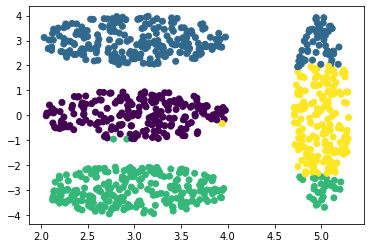

In [349]:
plt.scatter(X[:, 0], X[:, 1], c = Y_class)
plt.show()

In [350]:
import math as m
Y_class = []
for data_point in X:
  X_array = []
  for center in found_centers:
    X_array.append(LA.norm(center - data_point, ord = None))
  index = X_array.index(min(X_array))
  Y_class.append(index)


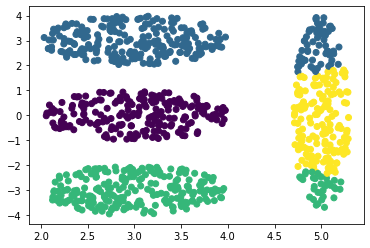

In [351]:
plt.scatter(X[:, 0], X[:, 1], c = Y_class)
plt.show()